<center><h1>Hong_Seungil_HW4</h1></center>

Name: Seungil Hong
<br>
Github Username: zonna19
<br>
USC ID: 2375832093 

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from builtins import range
import os
import glob
import re


Get the AReM Data Set

### (b) Splitting Data

In [2]:
def list_files_no_hidden(path):
    """Return a sorted list of all non-hidden files in the directory."""

    return sorted([f for f in glob.glob(os.path.join(path, '*')) if os.path.isfile(f) and not os.path.basename(f).startswith('.')])

def load_data(file, column_names):
    """Load data from a CSV file."""
    try:
        # Try reading the data
        raw_data = pd.read_csv(file, skiprows=5, header=None) # skip fist 5 rows of general info
        
        if raw_data.shape[1] != len(column_names):
            print(f"Warning: Mismatch in number of columns for file {file}. Expected {len(column_names)} but got {raw_data.shape[1]}.")
            return None 
        
        raw_data.columns = column_names
        return raw_data.replace(np.nan, 0)
    except pd.errors.ParserError:
        print(f"Error reading file: {file}")
        return None

def load_all_datasets(dir_path, folder_name_list, column_name_list, test_set_num):
    """Load all datasets from the directory."""
    dataset_dict = dict()
    tr_set, te_set = [], []

    for folder in folder_name_list:
        dataset_list = []
        path = os.path.join(dir_path, folder)
        files = list_files_no_hidden(path)
        # Sort files
        files_sorted = sorted(files, key=lambda x: int(re.search(r'\D*(\d+)', x).group(1)))
        set_num = test_set_num.get(folder, 3)
        print(f"\nLoading data for folder: {folder}")
        print(f"Using first {set_num} datasets for testing.")

        for idx, file in enumerate(files_sorted):
            data = load_data(file, column_name_list)
            dataset_list.append(data)
            if idx < set_num:
                te_set.append(data)
                print(f"Added dataset {idx+1} to test set.")
            else:
                tr_set.append(data)
                print(f"Added dataset {idx+1} to training set.")

        dataset_dict[folder] = dataset_list

    return dataset_dict, tr_set, te_set

# Constants
DIR_PATH = '../data/AReM/'
FOLDER_LIST = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
COLUMN_LIST = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
# Specify how many test sets there are per folder
TEST_SET_NUM = {'bending1': 2, 'bending2': 2}

dataset_dict, tr_set, te_set = load_all_datasets(DIR_PATH, FOLDER_LIST, COLUMN_LIST, TEST_SET_NUM)


Loading data for folder: bending1
Using first 2 datasets for testing.
Added dataset 1 to test set.
Added dataset 2 to test set.
Added dataset 3 to training set.
Added dataset 4 to training set.
Added dataset 5 to training set.
Added dataset 6 to training set.
Added dataset 7 to training set.

Loading data for folder: bending2
Using first 2 datasets for testing.
Added dataset 1 to test set.
Added dataset 2 to test set.
Added dataset 3 to training set.
Added dataset 4 to training set.
Added dataset 5 to training set.
Added dataset 6 to training set.

Loading data for folder: cycling
Using first 3 datasets for testing.
Added dataset 1 to test set.
Added dataset 2 to test set.
Added dataset 3 to test set.
Added dataset 4 to training set.
Added dataset 5 to training set.
Added dataset 6 to training set.
Added dataset 7 to training set.
Added dataset 8 to training set.
Added dataset 9 to training set.
Added dataset 10 to training set.
Added dataset 11 to training set.
Added dataset 12 to tr

### (c) Feature Extraction

#### i. Research 
#### Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

* Mean
* Median
* Variance, Standard Deviation
* Skewness: A measure of the asymmetry of the data distribution.
* Kurtosis: A measure of the tailedness of the data distribution.

#### ii. Extraction

In [3]:
# Function to extract features for a single column
def extract_features_for_column(series):
    return {
        'min': series.min(),
        'max': series.max(),
        'mean': series.mean(),
        'median': series.median(),
        'std': series.std(),
        '1st Quartile': series.quantile(0.25),
        '3rd Quartile': series.quantile(0.75)
    }

# Extract features for each dataset and store in a list
features_list = []

for folder in FOLDER_LIST:
    for dataset in dataset_dict[folder]:
        
        dataset_features = {}
        for idx, col in enumerate(COLUMN_LIST[1:], start=1):
            col_features = extract_features_for_column(dataset[col])
            for key, value in col_features.items():
                dataset_features[f"{key}{idx}"] = value
        features_list.append(dataset_features)

# Convert the list of feature dictionaries to a pandas DataFrame
instance_features = pd.DataFrame(features_list)
instance_features.index += 1 # start from 1

print(instance_features)


     min1   max1      mean1  median1      std1  1st Quartile1  3rd Quartile1  \
1   37.25  45.00  40.624792    40.50  1.476967          39.25        42.0000   
2   38.00  45.67  42.812812    42.50  1.435550          42.00        43.6700   
3   35.00  47.40  43.954500    44.33  1.558835          43.00        45.0000   
4   33.00  47.75  42.179812    43.50  3.670666          39.15        45.0000   
5   33.00  45.75  41.678063    41.75  2.243490          41.33        42.7500   
..    ...    ...        ...      ...       ...            ...            ...   
84  19.50  45.33  33.586875    34.25  4.650935          30.25        37.0000   
85  19.75  45.50  34.322750    35.25  4.752477          31.00        38.0000   
86  19.50  46.00  34.546229    35.25  4.842294          31.25        37.8125   
87  23.50  46.25  34.873229    35.25  4.531720          31.75        38.2500   
88  19.25  44.00  34.473188    35.00  4.796705          31.25        38.0000   

    min2   max2     mean2  ...      std

### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [4]:
# Define a global constant for random state to fix the dataset
np.random.seed(42)

# Number of bootstrap samples usually 1000 times widely used.
N_BST = 1000

# Function to generate a bootstrap sample
def bst_sample(data):
    return np.random.choice(data, size=len(data), replace=True)

# Function to compute bootstrap confidence interval for standard deviation
def bst_std_ci(data, alpha=0.10): # 90% C.I
    observed_std = np.std(data)
    bst_stds = []

    for _ in range(N_BST):
        sample = bst_sample(data)
        bst_stds.append(np.std(sample))
    
    lower = np.percentile(bst_stds, 100 * alpha / 2)
    upper = np.percentile(bst_stds, 100 * (1 - alpha / 2))
    
    mean_bst_std = np.mean(bst_stds)
    
    return observed_std, mean_bst_std, lower, upper

# Extract the standard deviation and confidence interval for each feature
bst_results = {
    'Feature': [],
    'Observed Std': [],
    'Bootstrap Std': [],
    'Lower 90% CI': [],
    'Upper 90% CI': []
}

for col in instance_features.columns:
    observed_std, mean_bst_std, lower, upper = bst_std_ci(instance_features[col])
    
    bst_results['Feature'].append(col)
    bst_results['Observed Std'].append(observed_std)
    bst_results['Bootstrap Std'].append(mean_bst_std)
    bst_results['Lower 90% CI'].append(lower)
    bst_results['Upper 90% CI'].append(upper)

# Convert to DataFrame and display
df_bst = pd.DataFrame(bst_results).round(3)
df_bst.set_index('Feature', inplace=True)
df_bst


Observed Std  Bootstrap Std  Lower 90% CI  Upper 90% CI
Feature                                                               
min1                  9.515          9.386         8.220        10.632
max1                  4.369          4.275         3.351         5.263
mean1                 5.305          5.257         4.693         5.868
median1               5.409          5.359         4.736         5.983
std1                  1.762          1.751         1.562         1.942
1st Quartile1         6.119          6.082         5.514         6.623
3rd Quartile1         5.110          5.060         4.363         5.808
min2                  0.000          0.000         0.000         0.000
max2                  5.034          4.999         4.601         5.373
mean2                 1.565          1.558         1.394         1.704
median2               1.404          1.395         1.226         1.526
std2                  0.879          0.874         0.800         0.935
1st Quartile2         0.941          0.937         0.828         1.031
3rd Quartile2         2.113          2.096         1.882         2.276
min3                  2.940          2.917         2.741         3.088
max3                  4.847          4.798         4.201         5.422
mean3                 3.986          3.948         3.414         4.496
median3               4.013          3.955         3.383         4.522
std3                  0.941          0.927         0.753         1.110
1st Quartile3         4.197          4.166         3.639         4.678
3rd Quartile3         4.148          4.128         3.585         4.666
min4                  0.000          0.000         0.000         0.000
max4                  2.171          2.154         1.959         2.355
mean4                 1.159          1.151         1.071         1.217
median4               1.139          1.130         1.050         1.192
std4                  0.456          0.453         0.419         0.486
1st Quartile4         0.839          0.834         0.772         0.885
3rd Quartile4         1.544          1.536         1.425         1.620
min5                  6.089          6.016         4.388         7.540
max5                  5.709          5.648         4.702         6.523
mean5                 5.643          5.553         4.418         6.705
median5               5.781          5.728         4.501         6.919
std5                  1.019          1.004         0.806         1.201
1st Quartile5         6.062          5.990         4.821         7.128
3rd Quartile5         5.500          5.412         4.347         6.458
min6                  0.046          0.034         0.000         0.078
max6                  2.505          2.484         2.237         2.746
mean6                 1.148          1.140         1.049         1.209
median6               1.080          1.071         0.989         1.138
std6                  0.515          0.511         0.477         0.543
1st Quartile6         0.754          0.749         0.683         0.803
3rd Quartile6         1.515          1.505         1.388         1.591

### iv. Use your judgement to select the three most important time-domain features

* Mean : is the key feature to tell the data
* Standard Deviation : Along with the mean, std tells dataset is how much are they spread. Also tells some indication of noises.
* Median

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [5]:
def segment_time_series(ts, L):
    """
    Segments the time series into L equal-length parts.
    """
    split_indices = np.array_split(range(len(ts)), L)
    return [ts.iloc[index] for index in split_indices]

def extract_features_from_segments(dataset, L, features):
    all_features = []
    for feature in features:
        ts = dataset[feature]
        segments = segment_time_series(ts, L)
        for seg in segments:
            info = pd.Series(seg).describe()
            all_features.extend([info['mean'], info['50%'], info['std']])
    return all_features

def extract_features(dataset, L, features, data_type='train'):
    feature_data = []
    activities = []

    cnt = 0
    for s in dataset:
        cnt += 1
        feature_data.append(extract_features_from_segments(s, L, features))
        
        if data_type == 'train':
            if cnt <= 9:
                activities.append('Bending')
            else:
                activities.append('Non-bending')
        elif data_type == 'test':
            if cnt <= 4:
                activities.append('Bending')
            else:
                activities.append('Non-bending')

    df = pd.DataFrame(feature_data)
    df['Activity'] = activities
    return df


features = ['avg_rss12', 'var_rss12', 'var_rss23']  # Corresponding to time series 1, 2, and 6
# Which later 0, 1, 5

In [6]:
# Breaking into L segments and extracting features
L = 1
df_train = extract_features(tr_set, L, features, data_type='train')
df_train

0      1         2         3      4         5         6     7  \
0   43.954500  44.33  1.558835  0.426250  0.470  0.338690  0.493292  0.43   
1   42.179812  43.50  3.670666  0.696042  0.500  0.630860  0.613521  0.50   
2   41.678063  41.75  2.243490  0.535979  0.500  0.405469  0.383292  0.43   
3   43.454958  43.25  1.386098  0.378083  0.470  0.315566  0.679646  0.50   
4   43.969125  44.50  1.618364  0.413125  0.470  0.263111  0.555312  0.49   
..        ...    ...       ...       ...    ...       ...       ...   ...   
64  33.586875  34.25  4.650935  4.576562  4.260  2.461077  3.259729  3.11   
65  34.322750  35.25  4.752477  4.456333  3.900  2.599284  3.432563  3.20   
66  34.546229  35.25  4.842294  4.371958  4.135  2.360448  3.338125  3.08   
67  34.873229  35.25  4.531720  4.380583  3.925  2.435437  3.424646  3.27   
68  34.473188  35.00  4.796705  4.359312  3.960  2.388746  3.340458  3.09   

           8     Activity  
0   0.513506      Bending  
1   0.524317      Bending  
2   0.389164      Bending  
3   0.622534      Bending  
4   0.487826      Bending  
..       ...          ...  
64  1.640243  Non-bending  
65  1.732727  Non-bending  
66  1.656742  Non-bending  
67  1.690960  Non-bending  
68  1.699114  Non-bending  

[69 rows x 10 columns]

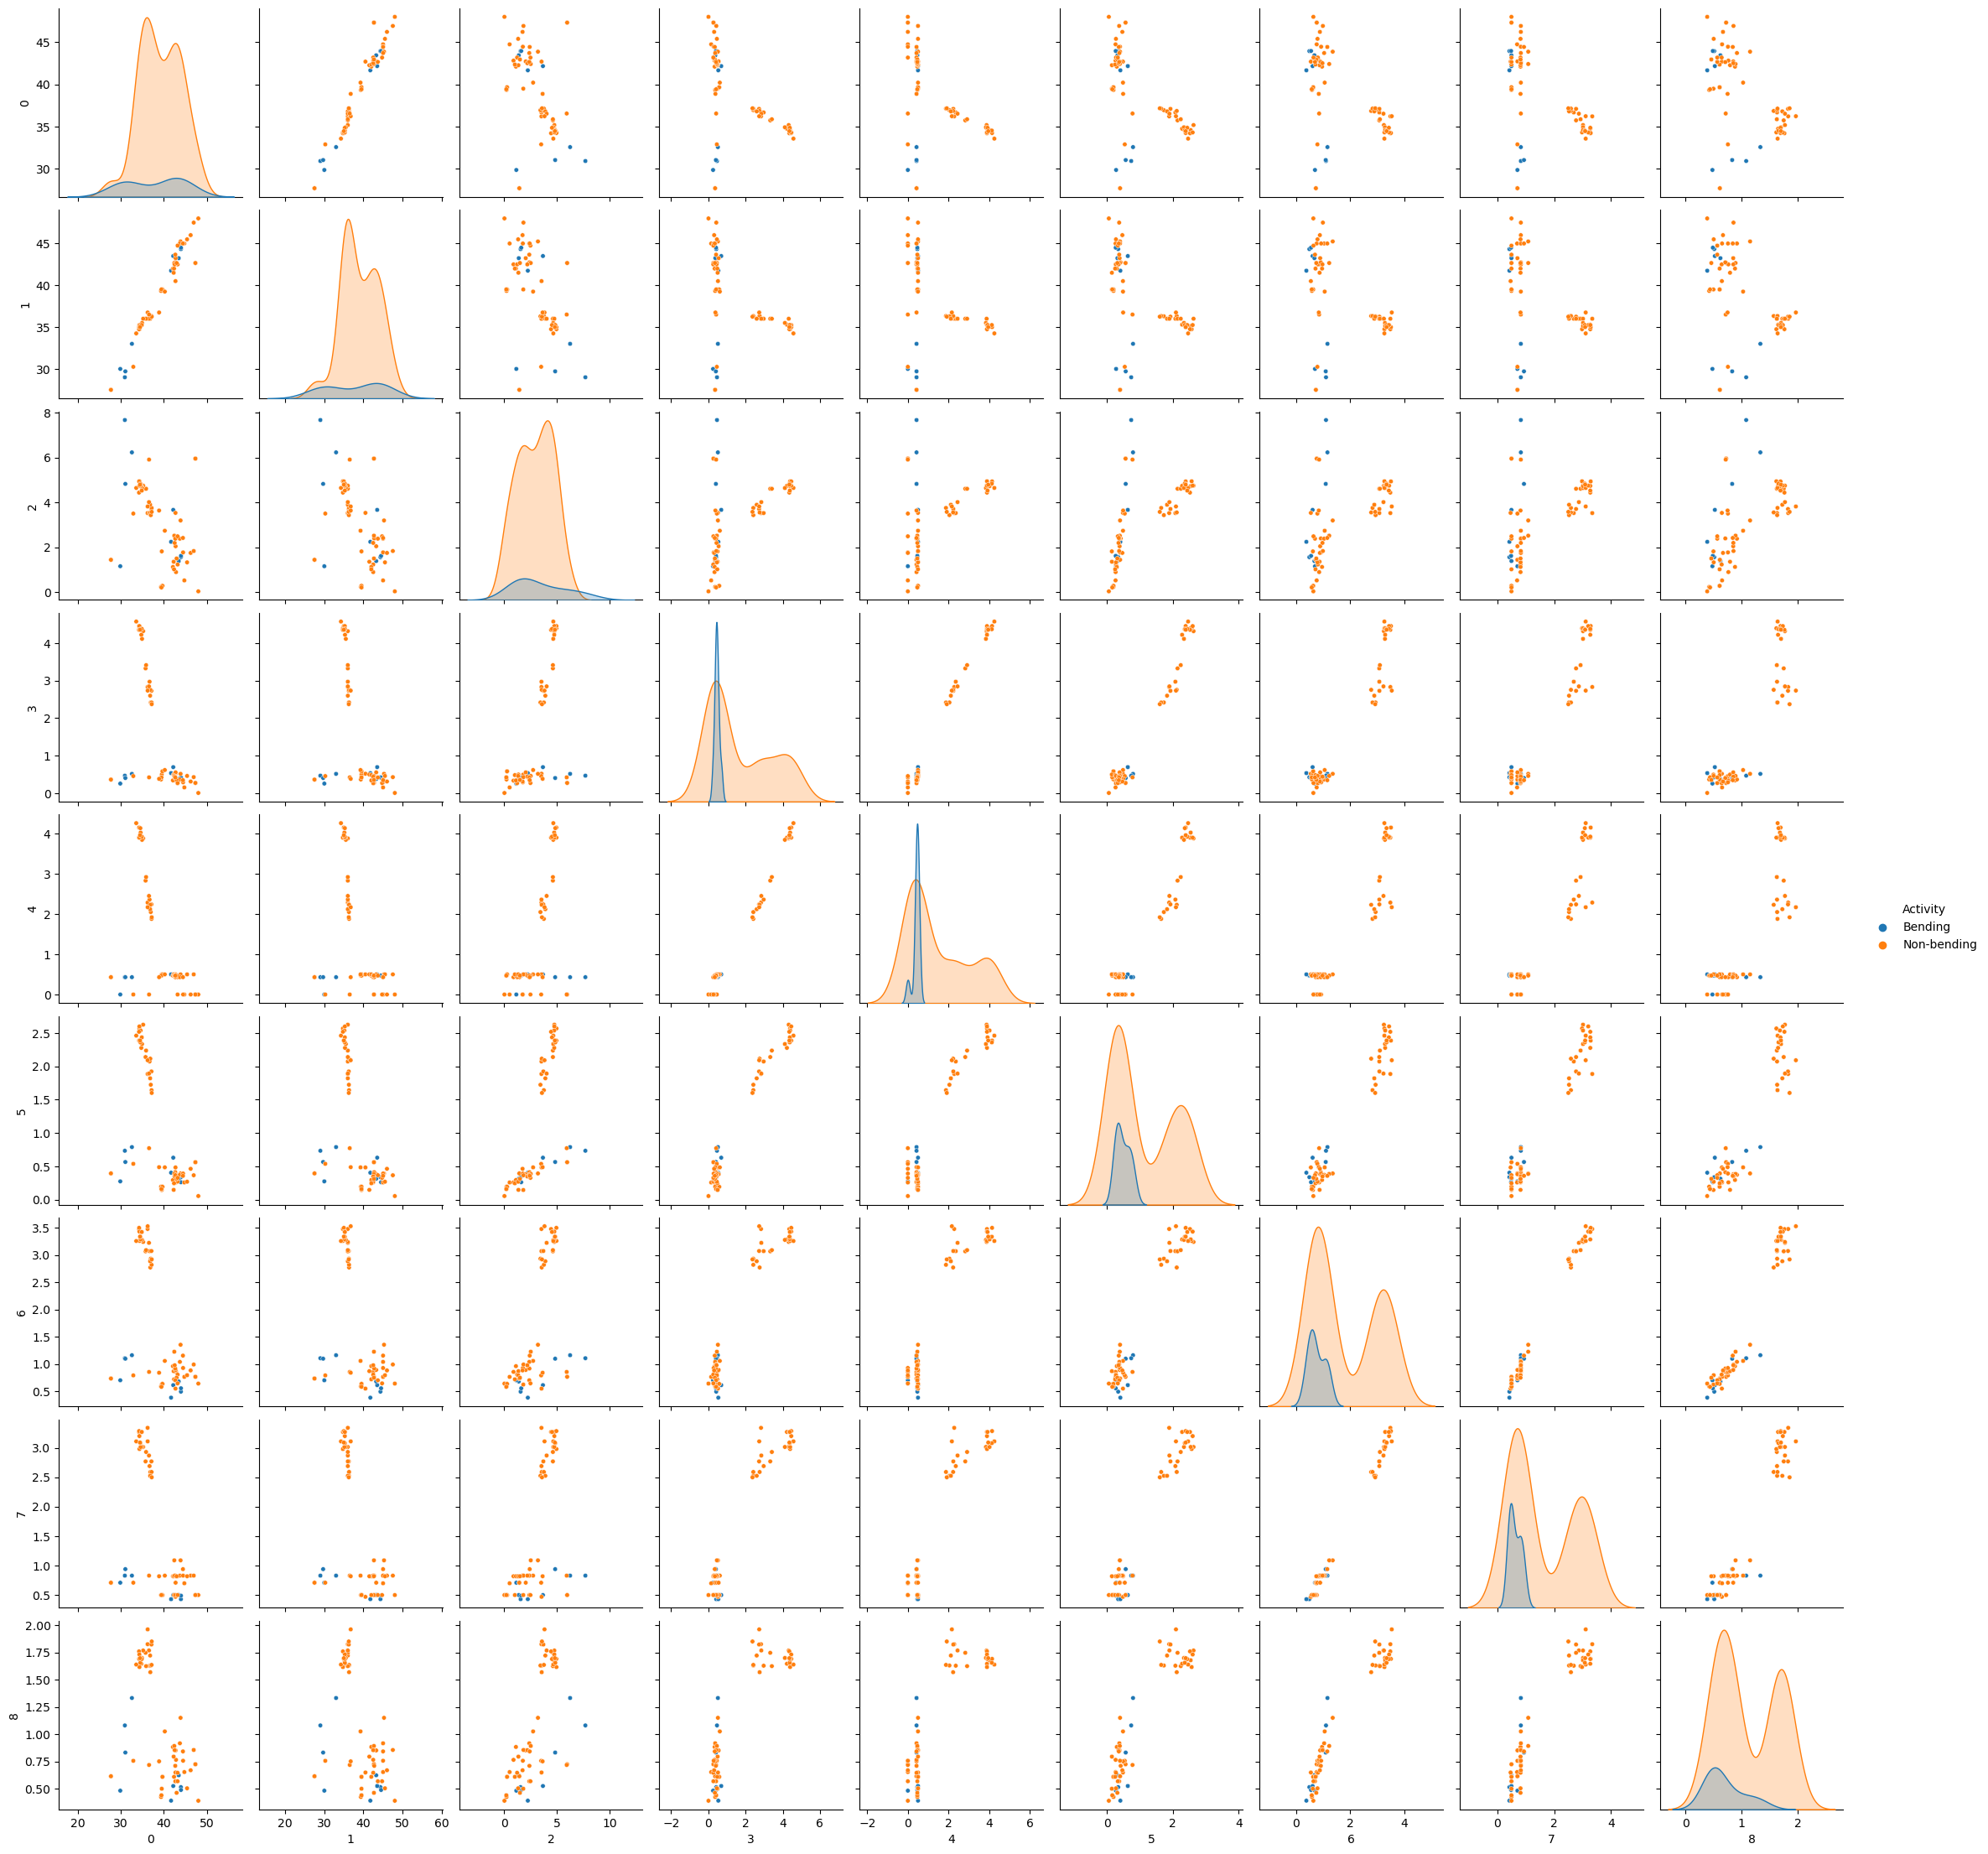

In [7]:
# Plotting scatter plots
sns.pairplot(df_train, hue='Activity', plot_kws={'s':15})

#### ii. Splitted Plots
Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [8]:
# Breaking into L segments and extracting features
L = 2
df_train = extract_features(tr_set, L, features, data_type='train')
df_train

0       1         2          3       4         5         6      7  \
0   44.057167  44.500  1.556971  43.851833  43.500  1.557168  0.381042  0.470   
1   43.278875  45.000  3.473355  41.080750  42.000  3.537481  0.673292  0.485   
2   41.621208  42.330  3.118644  41.734917  41.500  0.595920  0.623083  0.500   
3   44.117042  45.000  1.359836  42.792875  42.670  1.058792  0.250042  0.000   
4   43.486208  43.710  1.281976  44.452042  44.500  1.771251  0.378667  0.470   
..        ...     ...       ...        ...     ...       ...       ...    ...   
64  33.334500  34.000  4.874433  33.839250  34.500  4.411903  4.408083  4.195   
65  34.036750  34.415  4.872880  34.608750  35.500  4.621400  4.778292  4.030   
66  34.033875  35.000  4.758757  35.058583  35.875  4.880650  4.574625  4.470   
67  34.920792  35.330  4.272282  34.825667  35.250  4.785599  4.177958  3.865   
68  34.916792  35.375  4.634209  34.029583  34.500  4.923609  4.262333  3.850   

           8         9     10        11        12     13        14        15  \
0   0.329540  0.471458  0.500  0.342346  0.598250  0.500  0.526656  0.388333   
1   0.634285  0.718792  0.500  0.627915  0.640958  0.765  0.554542  0.586083   
2   0.489595  0.448875  0.500  0.273050  0.419083  0.430  0.411200  0.347500   
3   0.314099  0.506125  0.500  0.260761  0.815417  0.710  0.718016  0.543875   
4   0.284434  0.447583  0.500  0.235493  0.524875  0.470  0.486847  0.585750   
..       ...       ...    ...       ...       ...    ...       ...       ...   
64  2.196206  4.745042  4.320  2.694219  3.229167  3.110  1.637310  3.290292   
65  2.762730  4.134375  3.740  2.387460  3.543708  3.255  1.703098  3.321417   
66  2.391804  4.169292  3.880  2.315929  3.244042  2.980  1.619767  3.432208   
67  2.341763  4.583208  4.070  2.514203  3.430625  3.270  1.781928  3.418667   
68  2.396878  4.456292  4.195  2.381634  3.439917  3.200  1.737420  3.241000   

       16        17     Activity  
0   0.000  0.478528      Bending  
1   0.470  0.491873      Bending  
2   0.430  0.363144      Bending  
3   0.500  0.473445      Bending  
4   0.500  0.487918      Bending  
..    ...       ...          ...  
64  3.155  1.646023  Non-bending  
65  3.155  1.758379  Non-bending  
66  3.255  1.691050  Non-bending  
67  3.350  1.598536  Non-bending  
68  3.060  1.657578  Non-bending  

[69 rows x 19 columns]

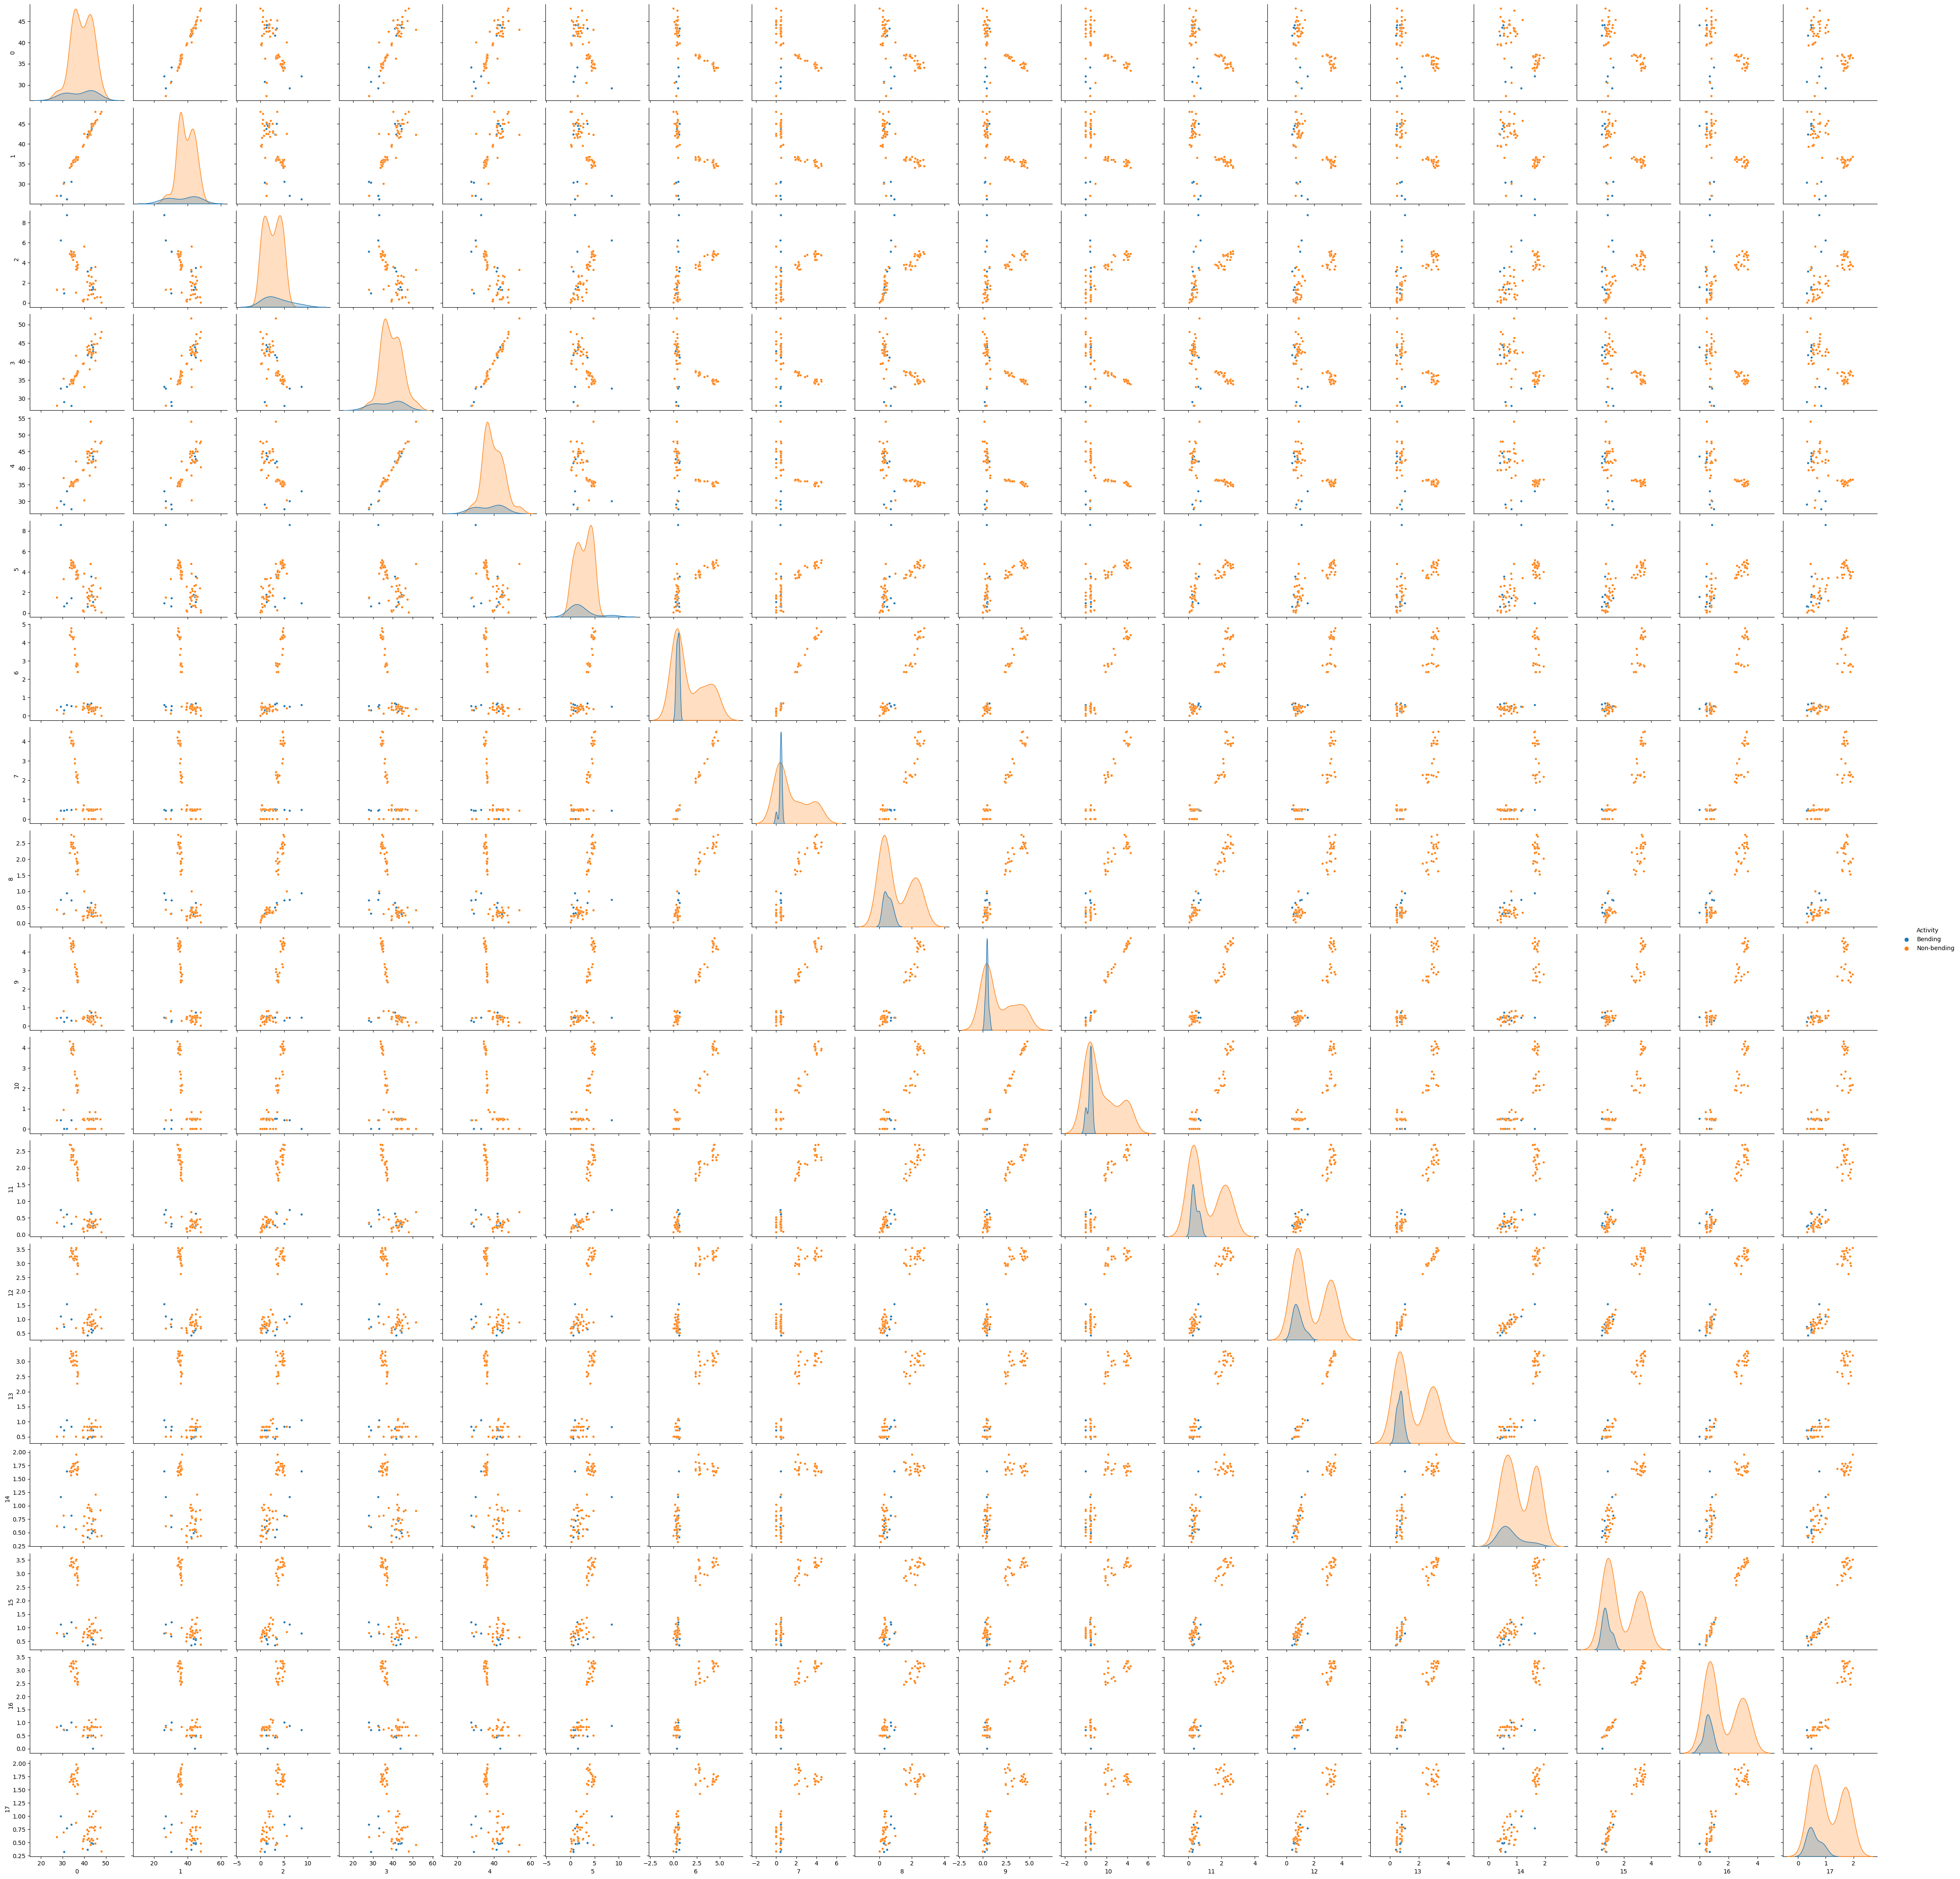

In [9]:
# Plotting scatter plots
sns.pairplot(df_train, hue='Activity', plot_kws={'s':15})

* Visually I do not see much differences betweeen base model versus ploting with the model splited first half and second half in terms of showing different patterns nor seeing clearer clusters than the original.

#### iii. Time Series Segments

In [10]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

for L in range(1, 21):  # or any range you want to test for
    # Extract Features for L segments
    df_train = extract_features(tr_set, L, features, data_type='train')
    X = df_train.drop(columns=['Activity'])
    y = (df_train['Activity'] == 'Bending').astype(int)  # convert to 0 and 1

    # Fit Logistic Regression using sklearn (this step is optional but often useful for cross-validation, etc.)
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    
    # Calculate p-values using statsmodels
    X_with_const = sm.add_constant(X)  # Adding constant for intercept in statsmodels
    try:
        sm_model = sm.Logit(y, X_with_const).fit(disp=0)
        print(f"For L={L}")
        print(sm_model.summary())
        print("="*60)
    except np.linalg.LinAlgError:
        print(f"Couldn't fit model for L={L} due to singular matrix.")
        print("="*60)

For L=1
                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            9
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                  0.5141
Time:                        17:13:01   Log-Likelihood:                -12.981
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                  0.001168
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6816      7.305      1.462      0.144      -3.636      24.999
0             -1.1658      0.621     -1.876      0.061      -2.384       0.052
1              0.9850      0.594      1.657 

* It seems having significant multicollinearity in the dataset. So most of P-value loop cannot work.

#### Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination

In [11]:
from sklearn.feature_selection import RFECV

for L in range(1, 21):
    # Extract Features for L segments
    df_train = extract_features(tr_set, L, features, data_type='train')
    X = df_train.drop(columns=['Activity'])
    y = (df_train['Activity'] == 'Bending').astype(int)  # convert to 0 and 1

    # Apply RFECV on Logistic Regression
    estimator = LogisticRegression(max_iter=1000)
    selector = RFECV(estimator, step=1, cv=5)
    X_selected = selector.fit_transform(X, y)

    # Extract the cross-validation accuracy for the optimal number of features
    cv_accuracy = selector.cv_results_['mean_test_score'][selector.n_features_ - 1]
    p = selector.n_features_

    print(f"\nNumber of Features for pair (L, P) = ({L}, {p}), from total number of features : {X.shape[1]}")
    print('Cross-Validation Accuracy:', round(cv_accuracy*100, 2),'%')
    print('Selected Features:', X.columns[selector.support_].tolist())  # To display the actual feature names


Number of Features for pair (L, P) = (1, 1), from total number of features : 9
Cross-Validation Accuracy: 87.03 %
Selected Features: [7]

Number of Features for pair (L, P) = (2, 4), from total number of features : 18
Cross-Validation Accuracy: 88.46 %
Selected Features: [2, 12, 15, 16]

Number of Features for pair (L, P) = (3, 12), from total number of features : 27
Cross-Validation Accuracy: 90.0 %
Selected Features: [2, 10, 11, 12, 16, 18, 19, 22, 23, 24, 25, 26]

Number of Features for pair (L, P) = (4, 1), from total number of features : 36
Cross-Validation Accuracy: 87.03 %
Selected Features: [33]

Number of Features for pair (L, P) = (5, 6), from total number of features : 45
Cross-Validation Accuracy: 88.46 %
Selected Features: [5, 30, 31, 39, 41, 42]

Number of Features for pair (L, P) = (6, 4), from total number of features : 54
Cross-Validation Accuracy: 88.46 %
Selected Features: [37, 48, 51, 52]

Number of Features for pair (L, P) = (7, 3), from total number of features :

#### Explain what the right way and the wrong way are to perform cross-validation in this problem.
> * Using RFECV method with cross-validation is the right way and only possibe way in this case. The p-value method wasn't able to correctly find the solutions maybe due to multicollinearity or over-specified models as seen from the high P-values across all different L s. It might have some situations like more predictors than observations.

#### iv. Confusion Matrix

#### Report the confusion matrix and show the ROC and AUC for your classifier on train data.

* Note :  In principle, fewer features can lead to simpler models which might generalize better. Given all this, while L=7 seems like a good choice since showed good cv-accuracy and not too many number of features.

#### Report the parameters of your logistic regression βi’s as well as the p-values associated with them

Confusion Matrix:
[[58  2]
 [ 3  6]]


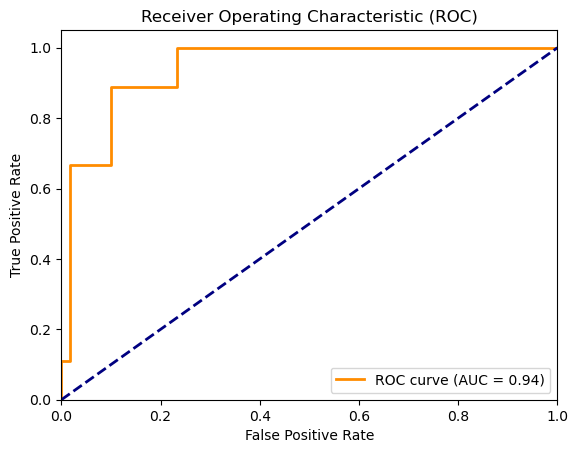

Optimization terminated successfully.
         Current function value: 0.172635
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                  0.5542
Time:                        17:18:57   Log-Likelihood:                -11.912
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.666e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4236      1.737      0.819      0.413      -1.981       4.829
5              1.1033      0

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Extract Features for L
L = 7 # Adjust value for any

df_train = extract_features(tr_set, L, features, data_type='train')
X = df_train.drop(columns=['Activity'])
y = (df_train['Activity'] == 'Bending').astype(int)

# Feature selection using RFECV for L
estimator = LogisticRegression(max_iter=1000)
selector = RFECV(estimator, step=1, cv=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]

# Fit Logistic Regression using sklearn with selected features
model = LogisticRegression(max_iter=1000)
model.fit(X_selected, y)

# Adjust threshold and predict
threshold = 0.25  # Default is 0.5
y_prob = model.predict_proba(X_selected)[:,1]
y_pred = [1 if prob > threshold else 0 for prob in y_prob]

cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC and AUC
y_prob = model.predict_proba(X_selected)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# the parameters Bi and their p-values using statsmodels
X_selected_with_const = sm.add_constant(pd.DataFrame(X_selected, columns=selected_features))
sm_model = sm.Logit(y, X_selected_with_const).fit()
print(sm_model.summary())


> Bening vs Non-beding is 15% (9/60) and this is considered imbalanced

#### v. Test Classifier

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Extract Features for L segments
df_train = extract_features(tr_set, L, features, data_type='train')
X_train = df_train.drop(columns=['Activity'])
y_train = (df_train['Activity'] == 'Bending').astype(int)

df_test = extract_features(te_set, L, features, data_type='test')
X_test = df_test.drop(columns=['Activity'])
y_test = (df_test['Activity'] == 'Bending').astype(int)
X_test

0      1         2          3      4         5          6      7   \
0   40.790000  41.00  0.940505  41.967391  42.00  0.118628  40.489275  40.67   
1   43.423913  43.50  0.343007  42.630290  42.50  0.511601  42.150725  42.00   
2   21.155797  21.33  2.762022  23.450580  24.25  3.054782  28.714928  28.00   
3   28.449130  27.33  1.466543  28.951014  29.20  0.860544  29.298261  29.33   
4   36.734348  35.50  3.860542  37.323478  37.00  3.270296  36.382754  35.25   
5   37.476087  37.00  3.092440  37.364348  36.25  2.813531  37.846232  37.00   
6   37.833333  36.67  3.225387  38.121449  37.25  3.559537  37.647681  37.33   
7   28.776667  29.00  0.707123  26.989130  27.00  0.795709  26.729420  27.00   
8   29.094058  29.00  0.507978  40.335652  47.00  8.720955  48.000000  48.00   
9   48.000000  48.00  0.000000  48.000000  48.00  0.000000  48.000000  48.00   
10  41.954203  42.00  0.139489  42.267101  42.50  0.738273  43.475652  43.50   
11  47.091739  48.00  1.990385  45.086667  45.00  0.149023  45.047391  45.00   
12  45.549130  45.50  0.471408  45.768116  46.00  0.641628  45.067536  45.00   
13  46.458841  46.50  0.525566  45.873188  45.75  0.728176  46.776957  46.75   
14  42.838986  43.25  1.481226  42.556812  42.75  1.323316  42.956377  44.00   
15  43.967536  44.67  1.845600  45.478116  45.50  0.393178  43.743623  44.25   
16  34.803768  36.00  4.740425  34.226377  35.67  4.866623  34.196522  35.75   
17  34.110580  35.00  4.765596  33.536377  34.00  4.857153  33.567101  34.50   
18  33.191739  33.75  4.449958  33.535362  34.50  5.168234  33.802899  34.50   

          8          9   ...        53        54     55        56        57  \
0   1.273018  39.758986  ...  0.630049  0.743235  0.830  0.415895  0.497059   
1   0.183490  41.804348  ...  0.618607  0.833382  0.830  0.693971  0.287353   
2   5.753023  24.983188  ...  1.023783  0.907500  0.710  0.792763  1.004559   
3   0.746139  29.575797  ...  0.511353  1.104853  1.090  0.783885  1.763088   
4   4.205651  37.547391  ...  2.030896  3.039559  2.570  1.928574  2.762647   
5   3.133868  37.422174  ...  1.900564  2.787941  2.490  1.848907  2.949853   
6   3.791733  37.093188  ...  1.832541  2.985588  2.620  1.816150  3.270000   
7   1.153132  26.630435  ...  0.749175  0.858529  0.820  0.618547  0.664265   
8   0.000000  48.016812  ...  0.883435  0.502941  0.500  0.399399  0.387794   
9   0.000000  48.003623  ...  0.487088  0.604412  0.500  0.361400  0.662794   
10  0.254584  43.472319  ...  0.575567  0.454265  0.450  0.315251  1.157206   
11  0.105589  46.411014  ...  0.913195  0.685882  0.470  0.598362  0.829118   
12  0.155917  45.219710  ...  0.550935  0.819412  0.830  0.555351  0.696176   
13  0.880021  45.052899  ...  0.906617  0.887353  0.710  0.822388  0.802941   
14  2.608199  44.623768  ...  0.660443  1.085441  0.870  0.863027  0.743676   
15  1.895810  45.171449  ...  0.720657  1.052206  0.850  0.910758  0.815882   
16  4.805915  33.570435  ...  1.616871  3.315882  2.860  1.913341  3.136765   
17  5.144039  33.820145  ...  1.933473  3.270588  2.915  1.796824  3.112941   
18  4.890841  34.026522  ...  1.124318  3.188088  2.490  1.888081  3.345735   

       58        59        60     61        62  
0   0.430  0.552668  0.373676  0.430  0.431443  
1   0.000  0.364760  0.337206  0.430  0.378173  
2   0.850  0.874490  0.641765  0.500  0.343902  
3   1.355  1.318954  1.908235  1.410  1.509044  
4   2.265  2.092060  2.684706  2.355  1.680839  
5   2.575  1.701504  2.407206  2.050  1.658057  
6   3.215  1.854074  3.906471  3.700  1.854154  
7   0.500  0.654724  0.910000  0.830  0.520840  
8   0.430  0.408214  0.418971  0.470  0.378974  
9   0.710  0.331941  0.656912  0.710  0.303144  
10  0.830  1.197722  1.283235  0.830  1.269772  
11  0.565  0.757022  1.634412  1.120  1.521294  
12  0.485  0.793633  0.519412  0.450  0.497081  
13  0.820  0.441419  0.905147  0.830  0.601641  
14  0.770  0.433000  0.795735  0.870  0.423533  
15  0.830  0.539876  1.008824  0.830  0.83230

In [14]:
# Apply RFECV on Logistic Regression for train data
estimator = LogisticRegression(max_iter=1000)
selector = RFECV(estimator, step=1, cv=5)
selector.fit(X_train, y_train)

# Transform both train and test data
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Fit Logistic Regression using sklearn with selected features from train data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_selected, y_train)

y_pred_prob = model.predict_proba(X_test_selected)[:, 1]
y_pred = [1 if p > threshold else 0 for p in y_pred_prob] # Using the same threshold for Test

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Cross-Validation Accuracy
cv_accuracy = selector.cv_results_['mean_test_score'][selector.n_features_ - 1]

print(f"Cross-Validation Accuracy for L = {L}: {cv_accuracy*100:.2f}%")

print(f"Test Accuracy at ({L},{selector.n_features_}) at threshold of {threshold}: {test_accuracy*100:.2f}%")


Cross-Validation Accuracy for L = 7: 91.43%
Test Accuracy at (7,3) at threshold of 0.25: 78.95%


#### vi. Separation

> It looks like they do have instability since due to incurring many singular matrix erros when there's multicollinearity, the estimation of coefficients becomes unstable. The values we get is seemed to be well-separated.

#### vii. Imbalance

> I can see that the first class has significantly more instances (60) than the second class (9). This is a 60:9 ratio (15%), which clearly suggests an imbalance between the two classes.

### Build a logistic regression model based on case-control sampling and adjust its parameters.

* Lecture note : SMOTE : synthetic minority over-sampling teq is a data sampling procedure that uses both up-sampling and down-sampling, depending on the class 
* SMOTE synthesizes new cases, To do this a data point is randomly selected from the minority class and its K-nearest neighbers (KNN) are determined

Confusion Matrix:
[[13  2]
 [ 0  4]]


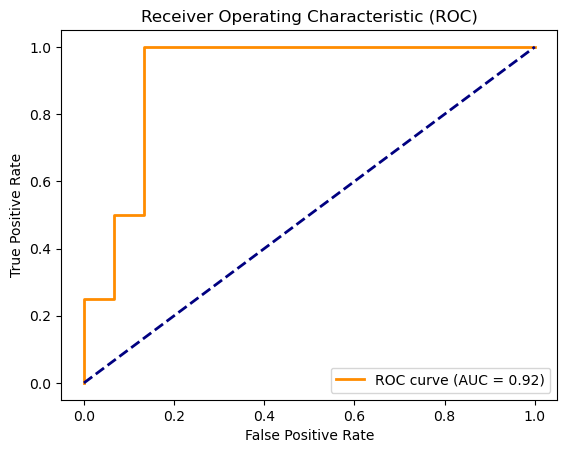

In [15]:
from imblearn.over_sampling import SMOTE

# Extract Features for L segments
df_train = extract_features(tr_set, L, features, data_type='train')
X_train = df_train.drop(columns=['Activity'])
y_train = (df_train['Activity'] == 'Bending').astype(int)

df_test = extract_features(te_set, L, features, data_type='test')
X_test = df_test.drop(columns=['Activity'])
y_test = (df_test['Activity'] == 'Bending').astype(int) 

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train a logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = [1 if prob > threshold else 0 for prob in y_pred_prob] # adjust this value based on your requirement

# Report Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

> The performance on the minority class (bending) has seen some improvement in terms of reducing false negatives (misclassifying bending as non-bending). However, the true positive rate hasn't improved much (6 before vs. 4 after). Given these results, it seems that while SMOTE may have made the model a bit better at identifying the minority class, it has done so at the expense of its performance on the majority class.

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [16]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# Define a range of values for l and C to cross-validate over
C_values = np.logspace(-4, 4, 9) # C is inverse Lamda

best_score = 0
best_l = None
best_C = None

scaler = StandardScaler()

for L in range(1, 21) :
    # Extract features based on current l value
    df_train = extract_features(tr_set, L, features, data_type='train')
    X_train_l = df_train.drop(columns=['Activity'])
    y_train_l = (df_train['Activity'] == 'Bending').astype(int)
    
    df_test = extract_features(te_set, L, features, data_type='test')
    X_test_l = df_test.drop(columns=['Activity'])
    y_test_l = (df_test['Activity'] == 'Bending').astype(int)

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train_l)
    X_test_scaled = scaler.transform(X_test_l)

    # L1-penalized logistic regression with cross-validation for C values
    model_l1 = LogisticRegressionCV(Cs=C_values, cv=5, penalty='l1', solver='liblinear') #l1 is penalty='l1'
    model_l1.fit(X_train_scaled, y_train_l)

    # Score the model on the test set
    score = model_l1.score(X_test_scaled, y_test_l)
    
    # Identify selected features
    coef = model_l1.coef_[0]
    selected_features = X_train_l.columns[coef != 0].tolist()

    # Update best score, l, and C if this score is better than previous best
    if score > best_score:
        best_score = score
        best_l = L
        best_C = model_l1.C_[0]  # This gives the best C value from the cross-validation

    # Print the results for the current iteration
    print(f"Results for l = {L}:")
    print(f"Cross-Validation Score: {model_l1.scores_[1].mean()*100:.2f}%")
    print(f"Selected Non-Zero features: {selected_features}")
    print(f"Test Accuracy: {score*100:.2f}%")
    print(f"Optimal C value: {model_l1.C_[0]}")
    print("-----------------------------------------------------------")

print("\nBest Results:")
print(f"Best l value: {best_l}")
print(f"Best C value: {best_C}")
print(f"Best accuracy: {best_score*100:.2f}%")


Results for l = 1:
Cross-Validation Score: 87.22%
Selected Non-Zero features: [0, 2, 5, 6, 7, 11, 12, 13, 14, 17, 20, 39, 40, 43, 44, 50, 53, 56, 58, 59, 61]
Test Accuracy: 84.21%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 2:
Cross-Validation Score: 87.22%
Selected Non-Zero features: [0, 2, 5, 6, 7, 11, 12, 14, 17, 20, 40, 43, 44, 50, 53, 56, 58, 59, 61]
Test Accuracy: 78.95%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 3:
Cross-Validation Score: 87.22%
Selected Non-Zero features: [0, 2, 5, 6, 7, 11, 12, 13, 14, 17, 20, 39, 40, 43, 44, 50, 53, 56, 58, 59, 61]
Test Accuracy: 84.21%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 4:
Cross-Validation Score: 86.89%
Selected Non-Zero features: [0, 2, 5, 6, 7, 11, 12, 13, 14, 17, 20, 39, 40, 43, 44, 50, 53, 56, 58, 59, 61]
Test Accuracy: 84.21%
Optimal C value: 100.0
----------------

KeyboardInterrupt: 

#### ii. Comparison

> L1-Penalized Regression performs better and much quicker since some insignificant coeffiecients are automatically shrunk to zero. P-Value method is very computationally cumbersome and sensitive to multicollinearity. Meanwhile, L1-Penalized Regression does have better test accuracies across all the Ls in this case as well.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [ ]:
def extract_all_features(dataset, L, features, data_type='train'):
    feature_data = []
    activities = []

    # Considering the sequence you provided during data loading
    activity_labels = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
    # Index at which each activity starts in the dataset
    activity_start_indices = {
        'train': [1, 6, 10, 22, 34, 46, 58],
        'test': [1, 3, 5, 8, 11, 14, 17]
    }
    
    cnt = 0
    for s in dataset:
        cnt += 1
        feature_data.append(extract_features_from_segments(s, L, features))
        
        # Check activity based on count and data type
        if cnt < activity_start_indices[data_type][1]:
            activities.append('bending1')
        elif cnt < activity_start_indices[data_type][2]:
            activities.append('bending2')
        elif cnt < activity_start_indices[data_type][3]:
            activities.append('cycling')
        elif cnt < activity_start_indices[data_type][4]:
            activities.append('lying')
        elif cnt < activity_start_indices[data_type][5]:
            activities.append('sitting')
        elif cnt < activity_start_indices[data_type][6]:
            activities.append('standing')
        else:
            activities.append('walking')
            
    df = pd.DataFrame(feature_data)
    df['Activity'] = activities
    return df


L = 1 # Reset the L

In [ ]:
df_train = extract_all_features(tr_set, L, features, data_type='train')
'''pd.set_option('display.max_rows', None)''' # Just to check classification columns are correct.
df_train

0      1         2         3      4         5         6     7  \
0   43.954500  44.33  1.558835  0.426250  0.470  0.338690  0.493292  0.43   
1   42.179812  43.50  3.670666  0.696042  0.500  0.630860  0.613521  0.50   
2   41.678063  41.75  2.243490  0.535979  0.500  0.405469  0.383292  0.43   
3   43.454958  43.25  1.386098  0.378083  0.470  0.315566  0.679646  0.50   
4   43.969125  44.50  1.618364  0.413125  0.470  0.263111  0.555312  0.49   
..        ...    ...       ...       ...    ...       ...       ...   ...   
64  33.586875  34.25  4.650935  4.576562  4.260  2.461077  3.259729  3.11   
65  34.322750  35.25  4.752477  4.456333  3.900  2.599284  3.432563  3.20   
66  34.546229  35.25  4.842294  4.371958  4.135  2.360448  3.338125  3.08   
67  34.873229  35.25  4.531720  4.380583  3.925  2.435437  3.424646  3.27   
68  34.473188  35.00  4.796705  4.359312  3.960  2.388746  3.340458  3.09   

           8  Activity  
0   0.513506  bending1  
1   0.524317  bending1  
2   0.389164  bending1  
3   0.622534  bending1  
4   0.487826  bending1  
..       ...       ...  
64  1.640243   walking  
65  1.732727   walking  
66  1.656742   walking  
67  1.690960   walking  
68  1.699114   walking  

[69 rows x 10 columns]

In [ ]:
df_test = extract_all_features(te_set, L, features, data_type='test')
df_test

0       1         2         3      4         5         6      7  \
0   40.624792  40.500  1.476967  0.358604  0.430  0.322605  0.570583  0.430   
1   42.812812  42.500  1.435550  0.372437  0.470  0.289158  0.571083  0.430   
2   24.562958  24.250  3.737514  0.590833  0.430  0.837408  0.700188  0.500   
3   27.464604  28.000  3.583582  0.449708  0.430  0.767197  1.122125  0.830   
4   37.177042  36.250  3.581301  2.374208  1.920  1.601799  2.921729  2.500   
5   37.561187  36.875  3.226507  2.080687  1.700  1.639258  2.765896  2.450   
6   37.058708  36.000  3.710180  2.438146  1.920  1.996887  2.983750  2.570   
7   27.716375  27.500  1.442253  0.363687  0.430  0.394817  0.734271  0.710   
8   44.182937  48.000  7.495615  0.101875  0.000  0.346756  0.692771  0.500   
9   48.004167  48.000  0.032038  0.007167  0.000  0.055106  0.641229  0.500   
10  42.363563  43.000  2.068247  0.492563  0.500  0.403581  1.034021  0.830   
11  45.917667  45.635  1.089027  0.324542  0.430  0.365820  0.904604  0.710   
12  45.239667  45.000  0.429915  0.172958  0.000  0.251176  0.837250  0.710   
13  44.334729  45.000  2.476940  0.432958  0.470  0.370591  0.933000  0.830   
14  43.174938  43.670  1.989052  0.506583  0.500  0.307413  0.911979  0.830   
15  42.760562  44.500  3.398919  0.486167  0.470  0.446511  0.842271  0.710   
16  34.227771  35.500  4.889576  3.995729  3.630  2.271102  3.394125  3.100   
17  33.509729  34.125  4.850923  4.450771  4.085  2.338685  3.378479  3.085   
18  34.660583  35.000  5.315110  4.200896  3.900  2.480206  3.244396  3.000   

           8  Activity  
0   0.582915  bending1  
1   0.601010  bending1  
2   0.693720  bending2  
3   1.012342  bending2  
4   1.852600   cycling  
5   1.769203   cycling  
6   1.815730   cycling  
7   0.613688     lying  
8   0.675781     lying  
9   0.388372     lying  
10  0.985627   sitting  
11  0.896171   sitting  
12  0.835344   sitting  
13  0.673609  standing  
14  0.666161  standing  
15  0.722165  standing  
16  1.792090   walking  
17  1.787360   walking  
18  1.630983   walking

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# Define a range of values for l and C to cross-validate over
C_values = np.logspace(-4, 4, 9) # C is inverse Lamda

L_values = list(range(1, 21))
cv_scores = []

for L in L_values:
    # Extract features using the current value of L
    df_train = extract_all_features(tr_set, L, features, data_type='train')
    X_train_l = df_train.drop(columns=['Activity'])
    y_train_l = df_train['Activity']
    
    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train_l)

    # Build L1-penalized multinomial logistic regression model
    multimodel_l1 = LogisticRegressionCV(Cs=C_values, penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, cv=5)
    multimodel_l1.fit(X_train_scaled, y_train_l)
    
    # Get the names of the selected features (non-zero coefficients)
    selected_features = np.where(multimodel_l1.coef_[0] != 0)[0]
    
    # Store mean of cross-validation scores
    score = np.mean(cross_val_score(multimodel_l1, X_train_scaled, y_train_l, cv=5))
    cv_scores.append(score)

    # Print the results
    print(f"Results for L = {L}:")
    unique_classes = multimodel_l1.classes_

    mean_scores = np.mean([value.mean() for value in multimodel_l1.scores_.values()])
    print(f"Average Cross-Validation Score: {mean_scores*100:.2f}%")
    print(f"Selected Non-Zero features: {selected_features}")
    print(f"Training Accuracy: {score*100:.2f}%")
    print(f"Optimal C value: {multimodel_l1.C_[0]}")
    print("-----------------------------------------------------------")

# Identify the best L based on cross-validation scores
best_L = L_values[np.argmax(cv_scores)]
print(f"The best L value is: {best_L}")

Results for l = 1:
Average Cross-Validation Score: 52.84%
Selected Non-Zero features: [0 1 2 3 4 5 6 7 8]
Training Accuracy: 73.74%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 2:
Average Cross-Validation Score: 48.66%
Selected Non-Zero features: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17]
Training Accuracy: 71.10%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 3:
Average Cross-Validation Score: 47.77%
Selected Non-Zero features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Training Accuracy: 69.45%
Optimal C value: 1000.0
-----------------------------------------------------------
Results for l = 4:
Average Cross-Validation Score: 50.07%
Selected Non-Zero features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Training Accuracy: 72.42%
Optimal C value: 1000.0
----------

### Report your test error.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Extract features using the best value of L for training data
df_train_best_L = extract_all_features(tr_set, best_L, features, data_type='train')
X_train_best_L = df_train_best_L.drop(columns=['Activity'])
y_train_best_L = df_train_best_L['Activity']

# Fit the model with the scaled training data
multimodel_best_l1 = LogisticRegressionCV(Cs=10, penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, cv=5)
multimodel_best_l1.fit(X_train_best_L, y_train_best_L)

# Extract features using the best value of L for test data
df_test = extract_all_features(te_set, best_L, features, data_type='test')
X_test_l = df_test.drop(columns=['Activity'])
y_test_l = df_test['Activity']

# Predict with the previously trained model with the best L value
y_pred = multimodel_best_l1.predict(X_test_l)

# Calculate the test accuracy and error
test_accuracy = accuracy_score(y_test_l, y_pred)
test_error = 1 - test_accuracy

# Print the results
print(f"Results for L = {best_L} on Test Data:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {test_error*100:.2f}%")
print("-----------------------------------------------------------")


Results for L = 6 on Test Data:
Test Accuracy: 63.16%
Test Error: 36.84%
-----------------------------------------------------------


* Do this again for standard scaled data

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Scaled data

# Extract features using the best value of L for training data
df_train_best_L = extract_all_features(tr_set, best_L, features, data_type='train')
X_train_best_L = df_train_best_L.drop(columns=['Activity'])
y_train_best_L = df_train_best_L['Activity']

# Scale the training data
scaler.fit(X_train_best_L)
X_train_best_scaled_l = scaler.transform(X_train_best_L)

# Fit the model with the scaled training data
multimodel_best_l1 = LogisticRegressionCV(Cs=10, penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, cv=5)
multimodel_best_l1.fit(X_train_best_scaled_l, y_train_best_L)

# Extract features using the best value of L for test data
df_test = extract_all_features(te_set, best_L, features, data_type='test')
X_test_l = df_test.drop(columns=['Activity'])
y_test_l = df_test['Activity']

# Scale the test data using the same scaler
X_test_scaled = scaler.transform(X_test_l)

# Predict with the previously trained model with the best L value
y_pred = multimodel_best_l1.predict(X_test_scaled)

# Calculate the test accuracy and error
test_accuracy = accuracy_score(y_test_l, y_pred)
test_error = 1 - test_accuracy

# Print the results
print(f"Results for L = {best_L} on Scaled Test Data:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {test_error*100:.2f}%")
print("-----------------------------------------------------------")


Results for L = 6 on Scaled Test Data:
Test Accuracy: 73.68%
Test Error: 26.32%
-----------------------------------------------------------


* Scaled dataset performs slightly better

### Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

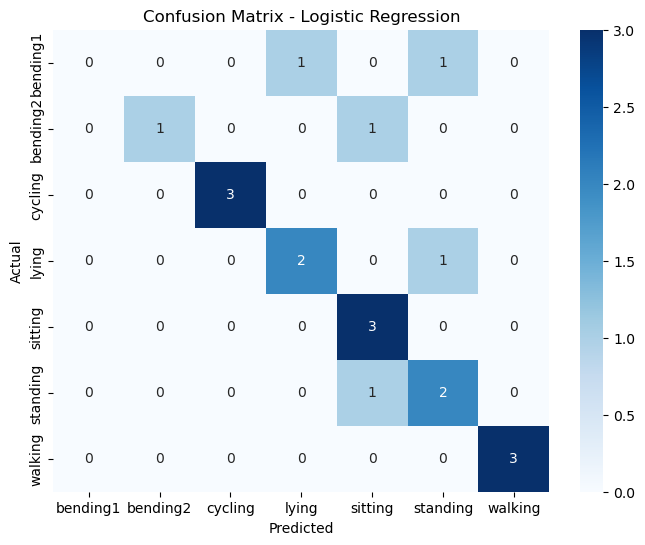

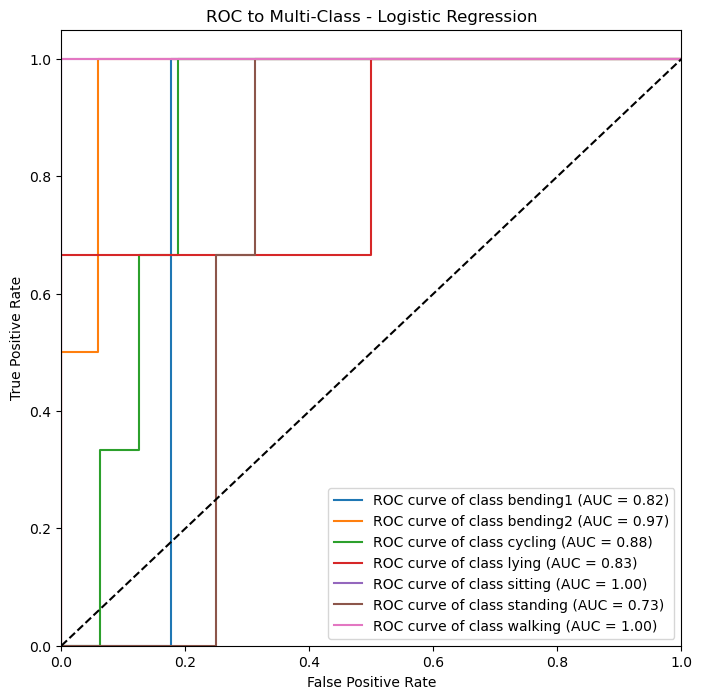

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute Confusion Matrix
confusion = confusion_matrix(y_test_l, y_pred)

# Plot Confusion Matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues, 
            xticklabels=multimodel_best_l1.classes_, 
            yticklabels=multimodel_best_l1.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve and AUC for each class
y_test_bin = label_binarize(y_test_l, classes=multimodel_best_l1.classes_)
n_classes = y_test_bin.shape[1]
y_score = multimodel_best_l1.decision_function(X_test_scaled)

# ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {multimodel_best_l1.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Multi-Class - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

#### ii. Naive Bayes

* Use unscaled data (otherwise it puts out error)

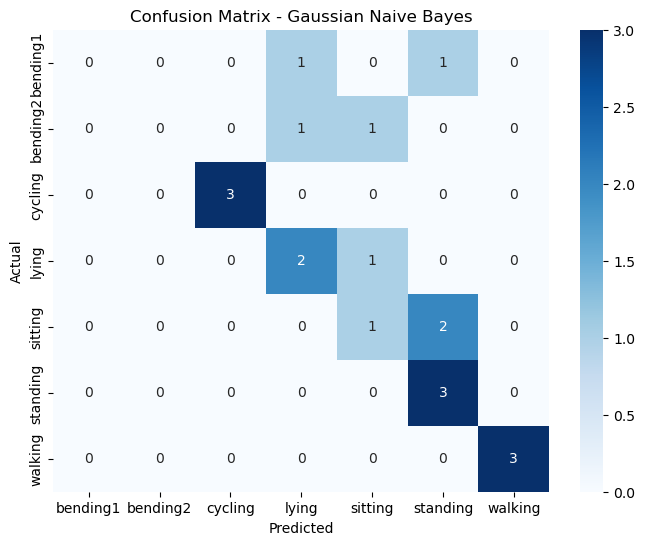

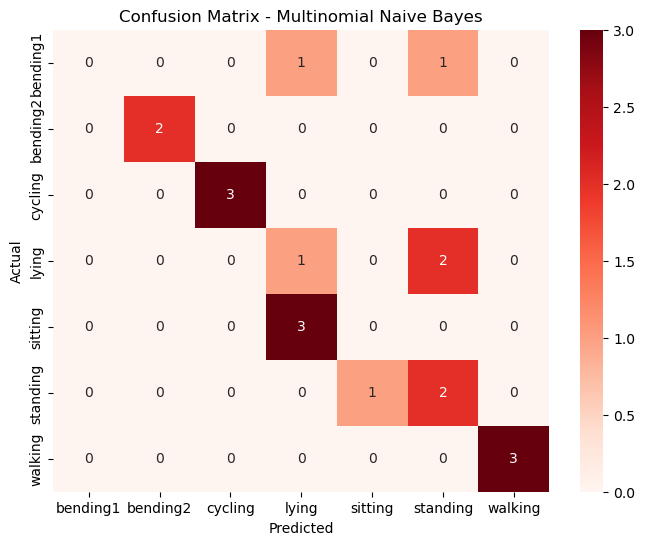

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Train the Gaussian Naïve Bayes classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_best_L, y_train_best_L)
y_pred_gaussian = gaussian_nb.predict(X_test_l)

# Train the Multinomial Naïve Bayes classifier
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train_best_L, y_train_best_L)

# Test Prediction
y_pred_multinomial = multinomial_nb.predict(X_test_l)

# Evaluate the Gaussian Naïve Bayes classifier
confusion_gaussian = confusion_matrix(y_test_l, y_pred_gaussian)

# Evaluate the Multinomial Naïve Bayes classifier
confusion_multinomial = confusion_matrix(y_test_l, y_pred_multinomial)

# Plot Confusion Matrix for Gaussian Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_gaussian, annot=True, fmt="d", cmap=plt.cm.Blues, 
            xticklabels=gaussian_nb.classes_, 
            yticklabels=gaussian_nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

# Plot Confusion Matrix for Multinomial Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_multinomial, annot=True, fmt="d", cmap=plt.cm.Reds, 
            xticklabels=multinomial_nb.classes_, 
            yticklabels=multinomial_nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()


* For ROC & AUC plots

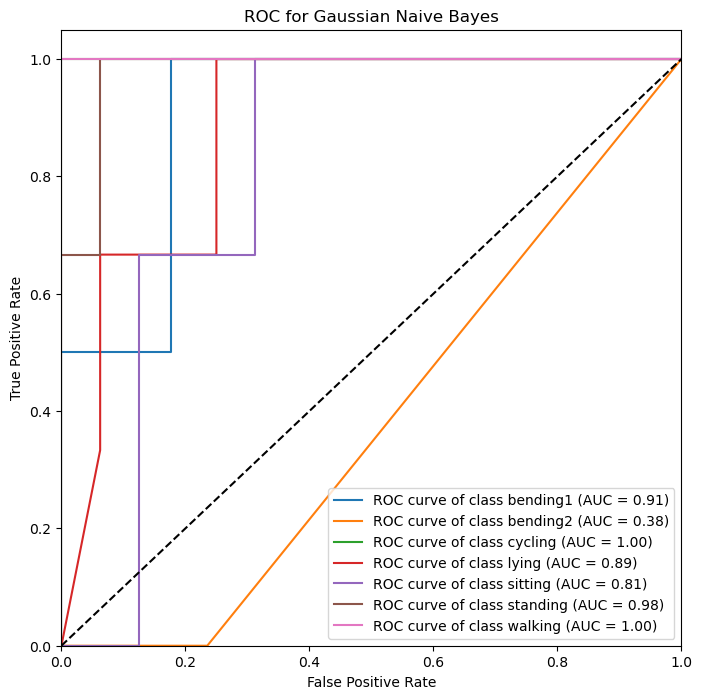

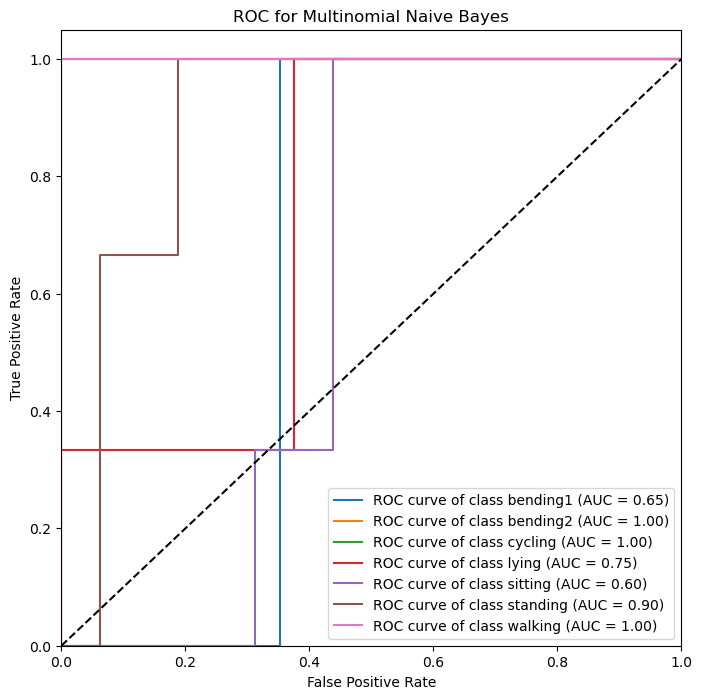

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get probability estimates for ROC computation
y_score_gaussian = gaussian_nb.predict_proba(X_test_l)
y_score_multinomial = multinomial_nb.predict_proba(X_test_l)

# Compute ROC curve and AUC for Gaussian Naïve Bayes
fpr_gaussian = dict()
tpr_gaussian = dict()
roc_auc_gaussian = dict()
for i in range(n_classes):
    fpr_gaussian[i], tpr_gaussian[i], _ = roc_curve(y_test_bin[:, i], y_score_gaussian[:, i])
    roc_auc_gaussian[i] = auc(fpr_gaussian[i], tpr_gaussian[i])

# Compute ROC curve and AUC for Multinomial Naïve Bayes
fpr_multinomial = dict()
tpr_multinomial = dict()
roc_auc_multinomial = dict()
for i in range(n_classes):
    fpr_multinomial[i], tpr_multinomial[i], _ = roc_curve(y_test_bin[:, i], y_score_multinomial[:, i])
    roc_auc_multinomial[i] = auc(fpr_multinomial[i], tpr_multinomial[i])

# Plot ROC curves for Gaussian Naïve Bayes
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr_gaussian[i], tpr_gaussian[i], label=f"ROC curve of class {gaussian_nb.classes_[i]} (AUC = {roc_auc_gaussian[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Multinomial Naïve Bayes
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr_multinomial[i], tpr_multinomial[i], label=f"ROC curve of class {multinomial_nb.classes_[i]} (AUC = {roc_auc_multinomial[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()


#### ii. Comparison

> 1. bending activities: All classifiers struggle with distinguishing between bending1 and bending2. However, the Gaussian Naive Bayes misclassifies bending activities to a wider variety of other activities, while the Multinomial version mostly confuses between the two bending types. Logistic Regression did the slightly better result among the others.
> 2. cycling and walking: All classifiers perform perfectly for these two activities.
> 3. lying and sitting: All classifiers exhibit similar behavior where they tend to confuse "lying" with "sitting" and vice versa.
> 4. standing: all classifiers did well with only minor errors.
> * None of the classifier is perfect, but by looking at ROC plot and AUC, it seems like the Logistic regression might be a bit more reliable for this dataset.

## 3. ISLR 4.8.3

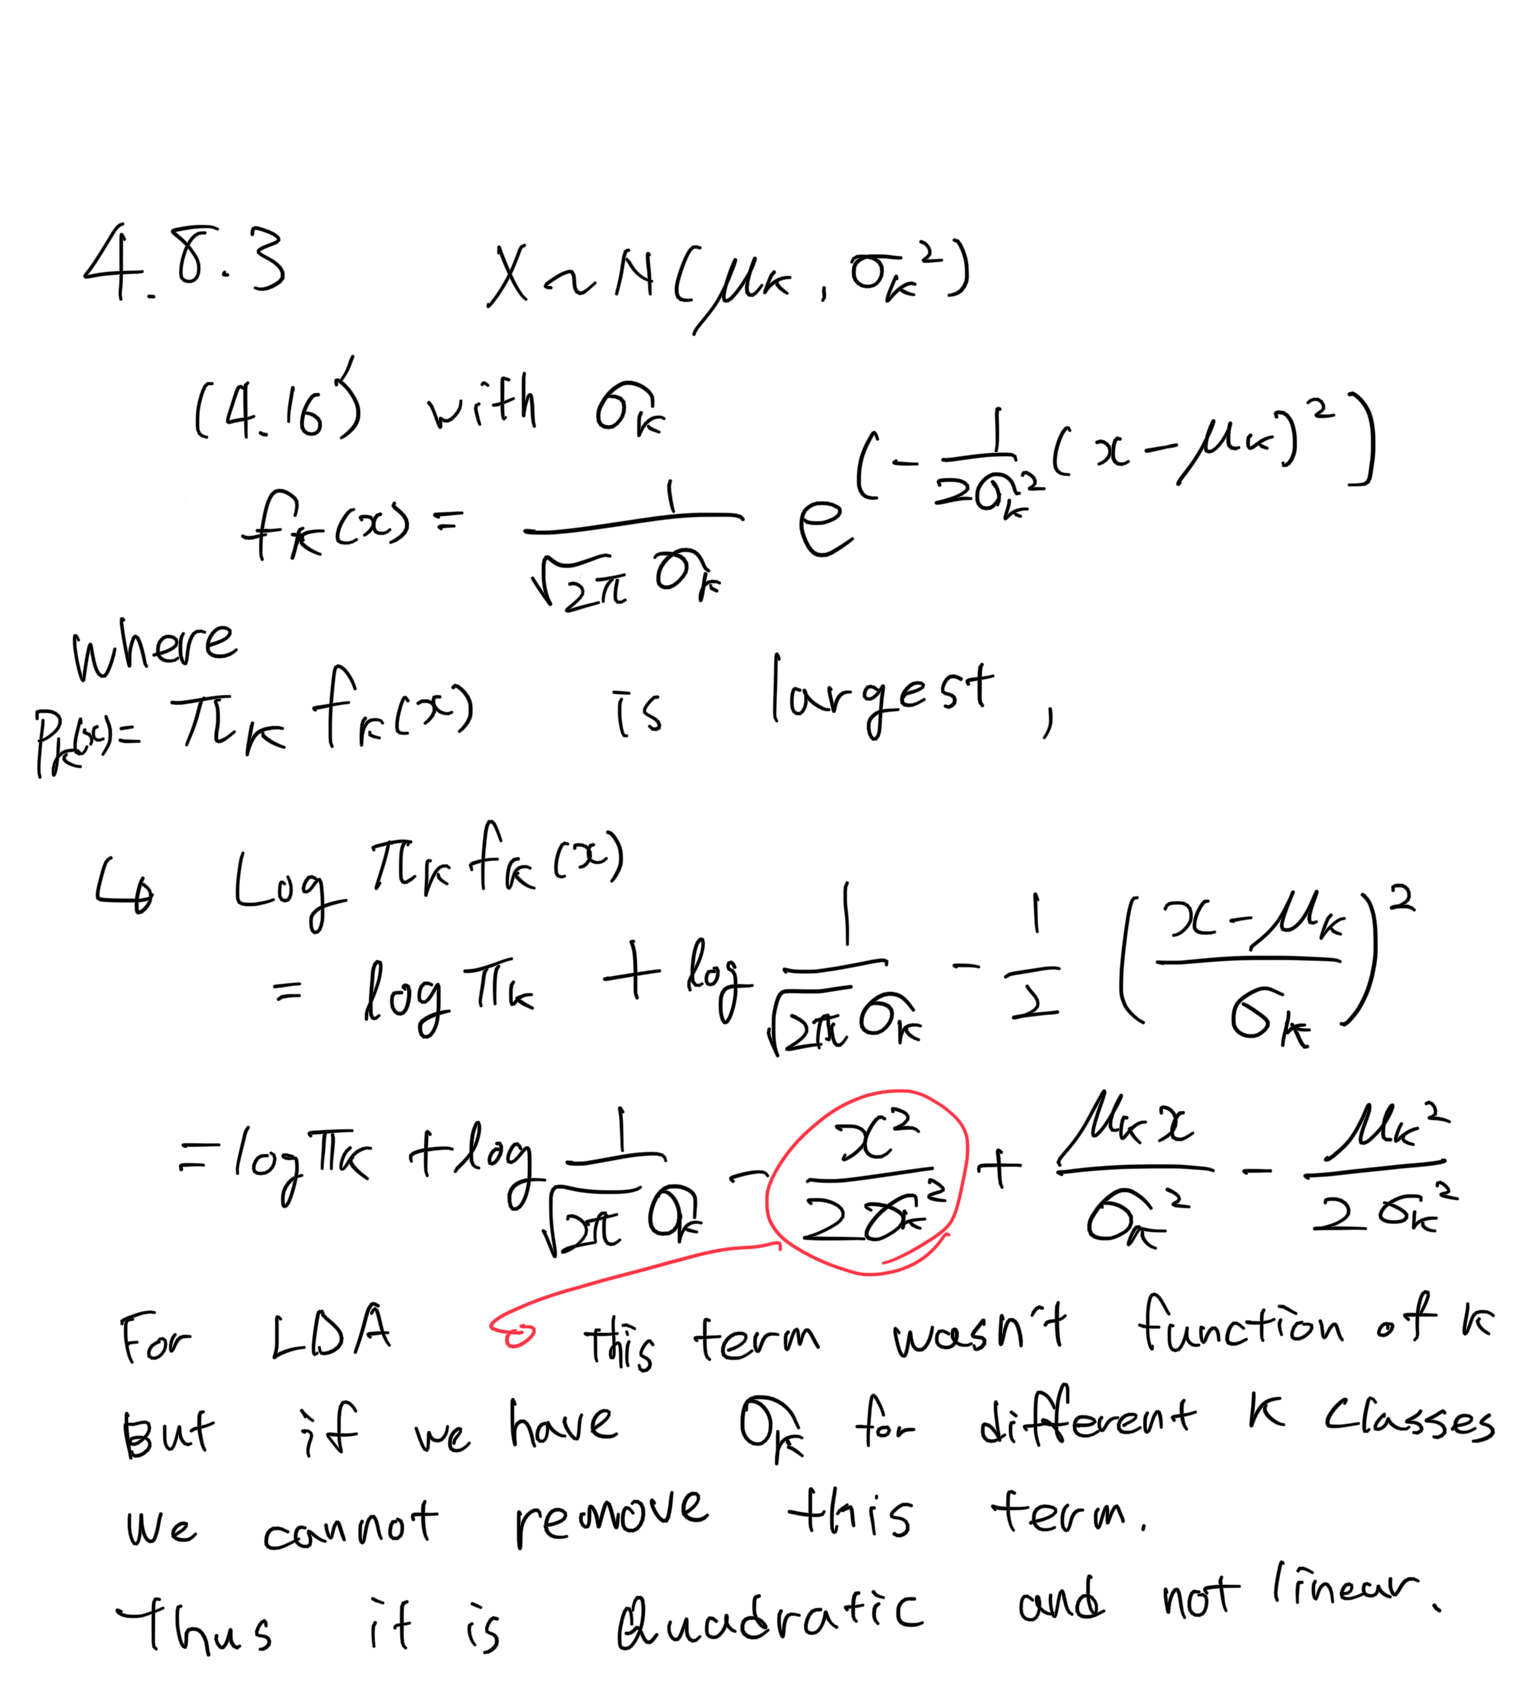

## 4. ISLR 4.8.7

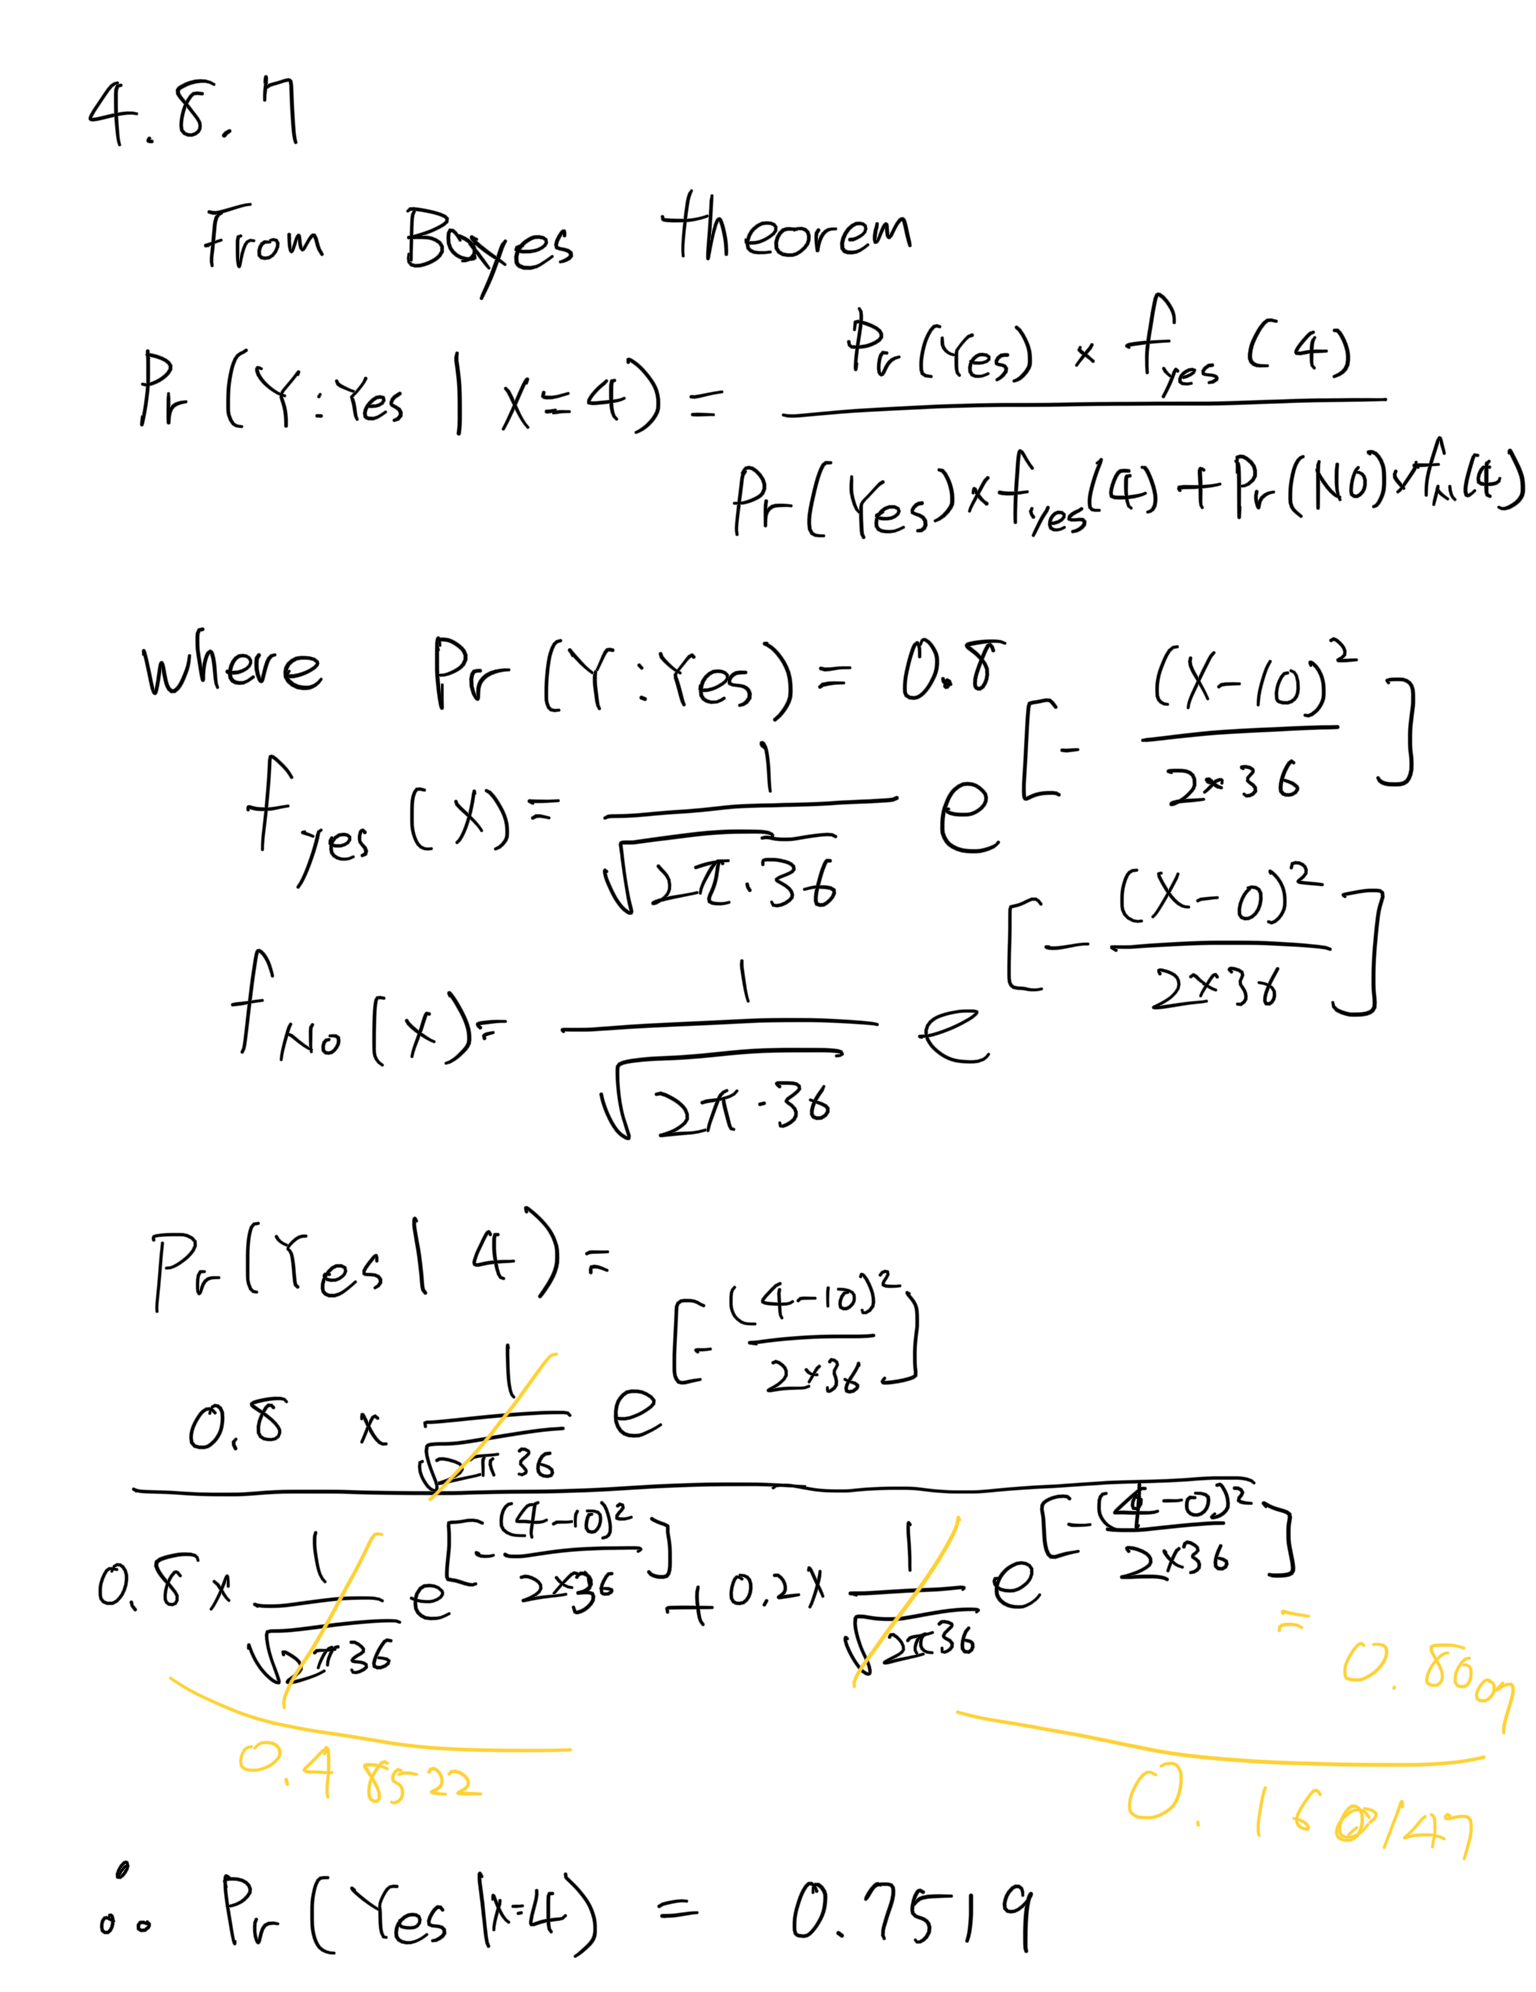

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9